In [2]:
# -*- coding: utf-8 -*-
# %matplotlib notebook
# %matplotlib inline
# %matplotlib widget

from config import config

import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import glob
import math
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix
from pylab import rcParams

In [3]:
#Tuning
dataset = config.DATASET
n_points = config.N_POINTS
cell = config.CELL
batch_size = config.BATCH_SIZE
epochs = config.EPOCHS
learning_rate = config.LEARNIG_RATE
num_classes = config.NUM_CLASSES
extension = config.EXTENSION
class_name = config.CLASS_NAME
optimizer = config.OPTIMIZER

In [4]:
train_or_test = ["train","test"]

# 関数

## ファイル読み込み

In [5]:
def load_off(filename):
    # read OFF file
    with open(filename,"r") as handle:
        off = handle.read().rstrip().split("\n")
        
    #OFFファイルが不正かどうか判定
    if off[0] != "OFF":
#         print("{} is broken!!".format(filename))
        params = list(off[0].split(" "))
        n_vertices = int(params[0].strip("OFF"))
        n_faces = int(params[1])
        off.insert(0, "OFF")
    
    else:
        #get params and faces
        params = list(map(int, off[1].split(" ")))
        n_vertices = params[0]
        n_faces = params[1]

    # read  Vertex coordinates
    vertices = []
    for n in range(n_vertices):
        coords = list(map(float, off[2+n].split()))
        vertices.append(coords)

    # read information of faces
    faces = []
    for n in range(n_faces):
        connects = list(map(int, off[2 + n_vertices + n].split(" ")[1:4]))
        faces.append(connects)

    return vertices, faces

In [6]:
def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]

In [7]:
def get_index_2d_list(retrieval_object,array):
    return [i for i, x in enumerate(retrieval_object) if x == array][0]

In [8]:
def load_stl(filename):
    # read STL file
    with open(filename,"r") as handle:
        stl = handle.read().rstrip().split("\n")
        
    #get vertice
    vertice = []
    for i in range(len(stl)):
        pool = stl[i].split()
        if pool[0] == "vertex":
            vertex = list(map(float, pool[1:]))
            vertice.append(vertex)
            
    unique_vertice = get_unique_list(vertice)
            
    #get faces
    faces = []
    for n in range(len(stl)):
        if stl[n].split() == ['outer', 'loop']:
            indexes = []
            for i in range(3):
                index = get_index_2d_list(unique_vertice, list(map(float,stl[n+i+1].split()[1:])))
                indexes.append(index)
            faces.append(indexes)

    return unique_vertice, faces

## 点群発生系

In [9]:
def generate_points(points, face_ids, num_generated_point=1000):
    
    points = np.array(points)
    face_ids = np.array(face_ids)
    
    # compute area
    vec1 = points[face_ids[:,0]] - points[face_ids[:,1]]
    vec2 = points[face_ids[:,1]] - points[face_ids[:,2]]
    cross_product = np.cross(vec1, vec2)
    area = np.sqrt(np.power(cross_product, 2).sum(axis=1))

    # cumsum area
    cum_area = np.cumsum(area)

    # generate random 
    random = np.random.rand(num_generated_point) * cum_area[-1]

    # convert random to index
    #random_idx = [bisect.bisect_left(cum_area, x) for x in random]
    random_idx = np.random.choice(np.arange(len(face_ids)), size=num_generated_point, p=area/cum_area[-1])

    #import pdb; pdb.set_trace()

    # generate points
    r1 = np.tile(np.random.rand(num_generated_point), (3, 1)).T
    r2 = np.tile(np.random.rand(num_generated_point), (3, 1)).T

    generated_points = (1 - np.sqrt(r1))*points[face_ids[random_idx, 0]] + np.sqrt(r1)*(1-r2)*points[face_ids[random_idx, 1]] + np.sqrt(r1)*r2*points[face_ids[random_idx, 2]]

    return generated_points, random_idx

## 可視化ツール

In [10]:
def plot3D(np_pc):
    #3D表示
    fig = plt.figure(1,figsize=(10, 10))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(np_pc[:,0], np_pc[:,1], np_pc[:,2],s = 100, marker="s", alpha=0.5,linewidths=2)
#     ax.scatter(np_pc[:,0], np_pc[:,1], np_pc[:,2],s = 100, marker="s", alpha=0.5)
#     ax.set_aspect('equal')
    plt.show()
    
    return 0

In [11]:
def plot_trihedral_figure_vox(np_pc):
    #Voxel版三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=10)
#         plt.xlim([-2,32]) 
#         plt.ylim([-2,32]) 
        plt.gca().set_aspect('equal')
        plt.show()
        plt.close()

In [12]:
def plot_trihedral_figure(np_pc):
    #三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=2)
        plt.axis('equal')
        plt.show()

In [13]:
def plot_confusion_matrix(data, 
                          label,
                          classes=class_name,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    labels_pred = model.predict_classes(data,verbose=0)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), labels_pred)
    np.set_printoptions(precision=2)
    cm_normalize = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(cm_normalize, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cnf_matrix.max() / 2
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    plt.savefig(fig_dir + 'Normalized_confusion_matrix.svg')
    plt.show()


## ボクセル系

In [14]:
def voxilize(np_pc,cell):
# ボクセル化した配列を返す
    max_dist = 0.0
    for it in range(0,3):
        # 最大値と最小値の距離を求める
        min_ = np.amin(np_pc[:,it])
        max_ = np.amax(np_pc[:,it])
        dist = max_-min_

        #xyzで一番並行距離が大きいのを求める
        if dist > max_dist:
            max_dist = dist
            
    for it in range(0,3):

        # 最大値と最小値の距離を求める
        min_ = np.amin(np_pc[:,it])
        max_ = np.amax(np_pc[:,it])
        dist = max_-min_
        
        #中心座標を 0,0,0にセットする（原点が中心にくるようにする）
        np_pc[:,it] = np_pc[:,it] - dist/2 - min_

        #covered cell
        cls = cell - 3

        #ボクセル一個当たりのサイズを求める
        vox_sz = max_dist/(cls-1)

        #上で算出した値で各点を割る。これで各点は(-14, 14)の範囲の値になる
        np_pc[:,it] = np_pc[:,it]/vox_sz

        #各点が全て正の整数になるよう移動。これで各点は[0, 30]になる（多分）
        np_pc[:,it] = np_pc[:,it] + (cls-1)/2


    #整数にする
    np_pc = np.rint(np_pc).astype(np.uint32)


    #３０＊３０＊３０の配列を作り，点が存在する場合は1、存在しない場合は0を入力する。
    vox = np.zeros([cell-2,cell-2,cell-2])

    # (pc_x, pc_y, pc_z)にnp_pcの座標を代入する
    for (pc_x, pc_y, pc_z) in np_pc:

#     # 点が存在しても20%の確率で0とし、データにノイズを加え、汎用性を上げている
#     # ここ，ノイジーなデータの場合８０よりも小さい数字にしたほうがいいかもね？
#         if random.randint(0,100) < 80:
        vox[pc_x, pc_y, pc_z] = 1

    np_vox = np.zeros([1,cell,cell,cell,1])
    np_vox[0, 1:-1, 1:-1, 1:-1,0] = vox

    return np_vox

In [15]:
def voxel_scatter(np_vox):
# キレイに整形するやつ
    #空の配列を作る
    vox_scat = np.zeros([0,3], dtype= np.uint32)

    #32回
    for x in range(0,np_vox.shape[1]):
        #32回
        for y in range(0,np_vox.shape[2]):
            #32回
            for z in range(0,np_vox.shape[3]):
                #（ｘ，ｙ，ｚ）に１が入っていればその座標を返す
                if np_vox[0,x,y,z,0] == 1.0:
                    arr_tmp = np.zeros([1,3],dtype=np.uint32)
                    arr_tmp[0,:] = (x,y,z)
                    vox_scat = np.concatenate((vox_scat,arr_tmp))
    return vox_scat

## ボクセル読み込み

In [16]:
def load_vox_stl(filename):
    #shape(N,1,32,32,32)の配列を返す
    vertices, faces = load_stl(filename)
    points,faces = generate_points(vertices, faces, n_points)
    # ValueError: sequence too large; cannot be greater than 32の回避策
    # list 2 numpy.ndarray
    pc = np.empty((len(points), len(points[0])))
    pc[:] = points
    vox = voxilize(pc,cell)

    return vox

In [17]:
def load_vox_off(filename):
    #shape(N,1,32,32,32)の配列を返す
    vertices, faces = load_off(filename)
#     points,face = gen_random_points(vertices, faces, n_points)
    points = gen_random_points(vertices, faces, n_points)
    # ValueError: sequence too large; cannot be greater than 32の回避策
    # list 2 numpy.ndarray
    pc = np.empty((len(points), len(points[0])))
    pc[:] = points
    vox = voxilize(pc,cell)

    return vox

# 可視化

In [18]:
# demo
vertices, faces = load_stl("3D_SAMPLE/spring/test/0.stl")
# vertices, faces = load_off("ModelNet10/chair/test/4.off")
points, faces = generate_points(vertices, faces, n_points)
# points = points.tolist()
# ValueError: sequence too large; cannot be greater than 32の回避策
# list 2 numpy.ndarray
test = np.empty((len(points), len(points[0])))
test[:] = points

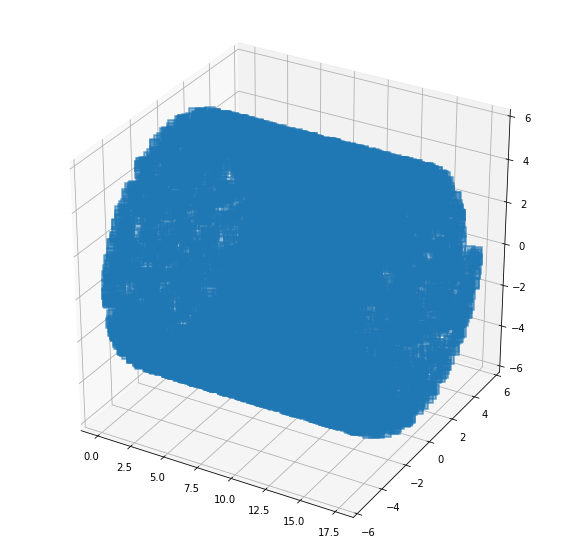

0

In [19]:
plot3D(test)

In [20]:
#voxelize
test_vox = voxilize(test,cell)

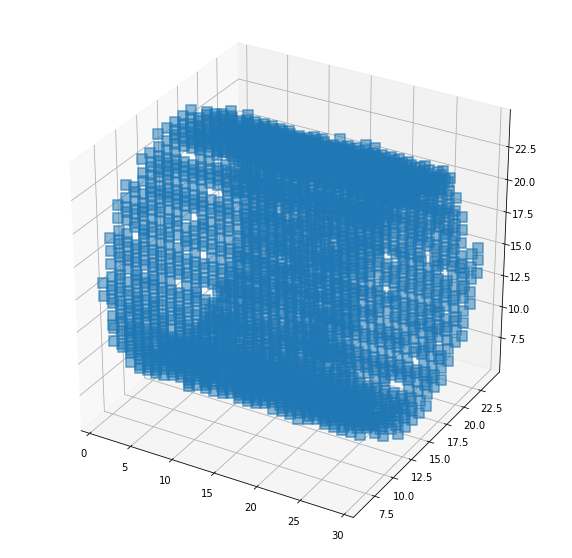

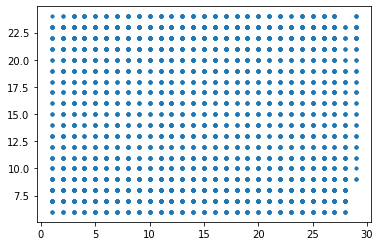

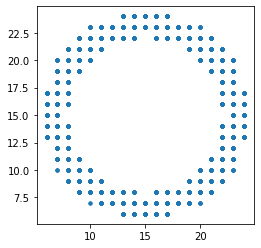

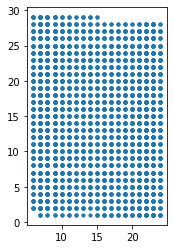

shape is (1, 32, 32, 32, 1)


In [21]:
#turn
vox_scat = voxel_scatter(test_vox)
plot3D(vox_scat)
plot_trihedral_figure_vox(vox_scat)
print("shape is {}".format(test_vox.shape))